In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class KalmanFilter:
    def __init__(self, state_dim, measurement_dim, control_dim=0):
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.control_dim = control_dim

        self.x = np.zeros((state_dim, 1))  # State estimate
        self.z = np.zeros((measurement_dim, 1))  # Measurement

        self.F = np.eye(state_dim)  # State transition matrix
        self.H = np.zeros((measurement_dim, state_dim))  # Measurement matrix

        self.u = np.zeros((control_dim, 1))  # Control input
        self.G = np.eye(state_dim, control_dim) if control_dim > 0 else None  # Control matrix

        self.P = np.eye(state_dim)  # State covariance
        self.Q = np.eye(state_dim)  # Process noise
        self.R = np.eye(measurement_dim)  # Measurement noise

        self.K = np.zeros((state_dim, measurement_dim))  # Kalman gain

        self.X_hist = []  # History of states
        self.P_hist = []  # History of covariances

    def set_transition_matrix(self, F): self.F = F
    def set_measurement_matrix(self, H): self.H = H
    def set_control_matrix(self, G): self.G = G
    def set_process_noise(self, Q): self.Q = Q
    def set_measurement_noise(self, R): self.R = R

    def state_extrapolation(self):
        if self.control_dim > 0 and self.G is not None:
            self.x = self.F @ self.x + self.G @ self.u
        else:
            self.x = self.F @ self.x

    def uncertainty_propagation(self):
        self.P = self.F @ self.P @ self.F.T + self.Q

    def compute_kalman_gain(self):
        S = self.H @ self.P @ self.H.T + self.R
        self.K = self.P @ self.H.T @ np.linalg.inv(S)

    def update_estimate(self):
        self.x = self.x + self.K @ (self.z - self.H @ self.x)

    def update_uncertainty(self):
        I = np.eye(self.state_dim)
        self.P = (I - self.K @ self.H) @ self.P

    def predict(self, u=None):
        if u is not None:
            self.u = u.reshape(-1, 1)
        self.state_extrapolation()
        self.uncertainty_propagation()
        return self.x.copy(), self.P.copy()

    def correct(self, z):
        self.z = z.reshape(-1, 1)
        self.compute_kalman_gain()
        self.update_estimate()
        self.update_uncertainty()
        return self.x.copy(), self.P.copy()

    def initialize(self, x0, P0):
        self.x = x0.reshape(self.state_dim, 1)
        self.P = P0.reshape(self.state_dim, self.state_dim)

    def step(self, z, u=None):
        self.predict(u)
        self.correct(z)
        self.X_hist.append(self.x.copy())
        self.P_hist.append(self.P.copy())
        return self.x.copy(), self.P.copy()

	Estimated state:
 [ 299.10716396  199.40832091   66.47298525 -398.27383762 -265.52061199
  -88.5115909 ],
 	Estimated covariance:
 [[  8.92857206   5.95248719   1.98426822   0.           0.
    0.        ]
 [  5.95248719 503.98617296 334.67990582   0.           0.
    0.        ]
 [  1.98426822 334.67990582 444.91702895   0.           0.
    0.        ]
 [  0.           0.           0.           8.92857206   5.95248719
    1.98426822]
 [  0.           0.           0.           5.95248719 503.98617296
  334.67990582]
 [  0.           0.           0.           1.98426822 334.67990582
  444.91702895]]
	Estimated state:
 [ 300.37082534  -28.2255886   -66.52999653 -378.48922238   64.87040914
  100.92734259],
 	Estimated covariance:
 [[  8.91749201  11.33495905   5.12597079   0.           0.
    0.        ]
 [ 11.33495905  61.10469961  75.43032599   0.           0.
    0.        ]
 [  5.12597079  75.43032599 126.49601894   0.           0.
    0.        ]
 [  0.           0.           0.    

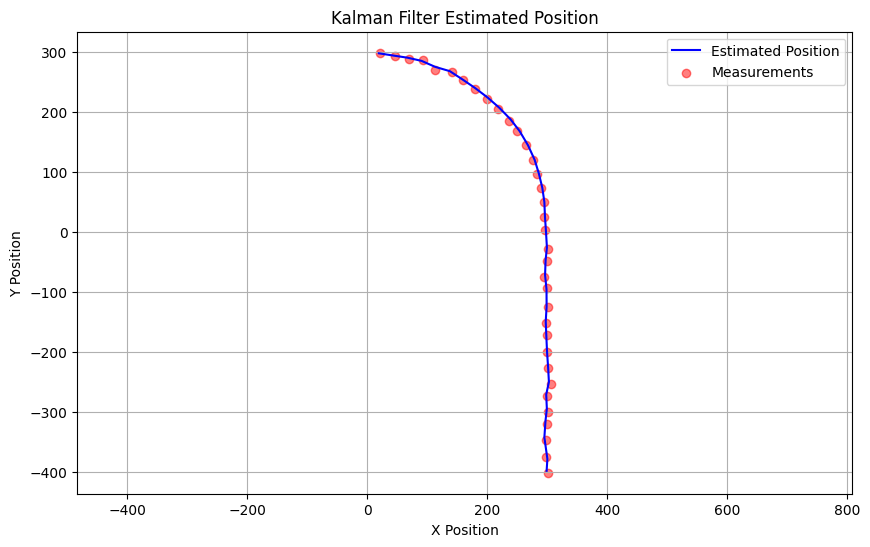

In [12]:
# Car 2D movement with constant acceleration and no control matrix example
# Define state and measurement dimensions
state_dim = 6 # [x, vx, ax, y, vy, ay]
# where x, y are positions, vx, vy are velocities, and ax, ay are accelerations
measurement_dim = 2  # [x, y]
# Initialize Kalman Filter
kf = KalmanFilter(state_dim, measurement_dim)
# Set matrices
delta_t = 1.0  # Time step
process_noise_std = 0.2  # Standard deviation for process noise
measurement_x_std = 3  # Standard deviation for measurement noise in x
measurement_y_std = 3  # Standard deviation for measurement noise in y
kf.set_transition_matrix(np.array([[1, delta_t, 0.5 * delta_t**2, 0, 0, 0],
                                     [0, 1, delta_t, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 1, delta_t, 0.5 * delta_t**2],
                                     [0, 0, 0, 0, 1, delta_t],
                                     [0, 0, 0, 0, 0, 1]]))
kf.set_measurement_matrix(np.array([[1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 1, 0, 0]]))

# set uncorrelated process noise
kf.set_process_noise(np.array([[delta_t**4 / 4, delta_t**3 / 2, delta_t**2 / 2, 0, 0, 0],
                               [delta_t**3 / 2, delta_t**2, delta_t, 0, 0, 0],
                               [delta_t**2 / 2, delta_t, 1, 0, 0, 0],
                               [0, 0, 0, delta_t**4 / 4, delta_t**3 / 2, delta_t**2 / 2],
                               [0, 0, 0, delta_t**3 / 2, delta_t**2, delta_t],
                               [0, 0, 0, delta_t**2 / 2, delta_t, 1]]) * process_noise_std**2)
# set uncorrelated measurement noise
kf.set_measurement_noise(np.array([[measurement_x_std**2, 0],
                                     [0, measurement_y_std**2]]))

# initialization
x0 = np.array([0]*6)
p0 = np.diag([500]*6)

kf.initialize(x0, p0)

# Simulate some measurements
x_values = [
    301.5, 298.23, 297.83, 300.42, 301.94, 299.5, 305.98, 301.25,
    299.73, 299.2, 298.62, 301.84, 299.6, 295.3, 299.3, 301.95, 296.3,
    295.11, 295.12, 289.9, 283.51, 276.42, 264.22, 250.25, 236.66, 217.47,
    199.75, 179.7, 160, 140.92, 113.53, 93.68, 69.71, 45.93, 20.87
]

y_values = [
    -401.46, -375.44, -346.15, -320.2, -300.08, -274.12, -253.45, -226.4,
    -200.65, -171.62, -152.11, -125.19, -93.4, -74.79, -49.12, -28.73, 2.99,
    25.65, 49.86, 72.87, 96.34, 120.4, 144.69, 168.06, 184.99, 205.11,
    221.82, 238.3, 253.02, 267.19, 270.71, 285.86, 288.48, 292.9, 298.77
]

z = [np.array([x, y]) for x, y in zip(x_values, y_values)]

# Run the Kalman filter on the measurements
for measurement in z:
    x_est, p_est = kf.step(measurement)
    print(f"\tEstimated state:\n {x_est.flatten()},\n \tEstimated covariance:\n {p_est}")
    # You can also access the history of states and covariances if needed
    # print(f"State history: {kf.X_hist[-1].flatten()}, Covariance history: {kf.P_hist[-1]}")


# Plot the estimated positions
x_hist = np.array([x.flatten() for x in kf.X_hist])
plt.figure(figsize=(10, 6))
plt.plot(x_hist[:, 0], x_hist[:, 3], label='Estimated Position', color='blue')
plt.scatter(x_values, y_values, label='Measurements', color='red', alpha=0.5)
plt.title('Kalman Filter Estimated Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()